# Tracking Code

Track a spherical colloid from Mie-holography videos. Results are saved in SI, in a .mat file. 

Usage: Start from .p4 videos. Copy-past the track.ipynb code to the folder containing the video. Not necessary but helps keeping track of what is done during the tracking.

To install the required packages: see associated note.

# Importations

In [1]:
import sys

In [2]:
import os
os.environ.setdefault("OMP_NUM_THREADS","1") # export OMP_NUM_THREADS=1
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1") # export OPENBLAS_NUM_THREADS=1
os.environ.setdefault("MKL_NUM_THREADS","1") # export MKL_NUM_THREADS=1
os.environ.setdefault("VECLIB_MAXIMUM_THREADS","1") # export VECLIB_MAXIMUM_THREADS=1
os.environ.setdefault("NUMEXPR_NUM_THREADS","1") # export NUMEXPR_NUM_THREADS=1

'1'

In [3]:
# Check python version 
# Should be the one installed: python 3.9
print(sys.version)
# Check which executable 
print()
print(sys.executable)
# And what is in the path
print()
print(sys.path)

3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]

/home/n.fares/.conda/envs/holography/bin/python

['/home/n.fares/.conda/envs/holography/lib/python39.zip', '/home/n.fares/.conda/envs/holography/lib/python3.9', '/home/n.fares/.conda/envs/holography/lib/python3.9/lib-dynload', '', '/home/n.fares/.conda/envs/holography/lib/python3.9/site-packages']


In [4]:
# sys.path.insert(0, '/path/to/other/env/lib/python3.9/site-packages')

In [5]:
import subprocess
import glob

In [6]:
import wraplorenzmie

	No module named 'numba'
INFO:configuration: Falling back to standard implementation
	No module named 'numba'
INFO:configuration: Falling back to standard implementation


In [7]:
from wraplorenzmie.pylorenzmie.utilities import azimedian, azistd

In [8]:
%matplotlib widget
import ipywidgets as widgets

In [9]:
import wraplorenzmie.utilities.utilities as utilities

import wraplorenzmie.fits.fit as fit
#import imageio
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#sns.set(style='white', font_scale=2)
%matplotlib inline
import matplotlib as mpl

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=False)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')

def cm2inch(value):
    return value/2.54

In [10]:
from scipy.io import savemat

# Inputs

In [11]:
# Calibration (um/px)
calib = 0.05799
# Wavelength of the illumination (must be in um)
wavelength = 0.532
# Acquisition framerate
fps = 100
# Liquid's medium
n_m = 1.33

In [12]:
# Filename for the video
filename = glob.glob("*.mp4")[0]

In [13]:
foldername = os.path.basename(os.getcwd())
foldername

'tracking'

In [14]:
# If you want to trim the video, uncomment the next couple of cells.

In [15]:
# filename_trimmed = filename[:-4] + "_trimmed_start_at_5min.mp4"

# from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
# ffmpeg_extract_subclip(filename, 5*60, 1000*60, targetname=filename_trimmed[:])

In [16]:
# filename = filename_trimmed

In [17]:
filename

'Basler_acA1920-155um__22392621__20230310_132632377.mp4'

In [18]:
# Create the python's object (class) corresponding to the video
vid = utilities.video_reader(filename)

In [19]:
# Get the number of images in the video
try:
    cmd = r"ffprobe -v error -select_streams v:0 -count_packets -show_entries stream=nb_read_packets -of csv=p=0 " + filename
    nb_image = int(subprocess.check_output(cmd, shell=True))
except:
    print('Something went wrong. Please enter the number of images manually.')
    nb_image = int(input())
print(nb_image)

126444


In [20]:
# Update vid
vid.number = nb_image

# Work On One Image

In [21]:
# Change if you want to start at something else than first frame
n_start = 0

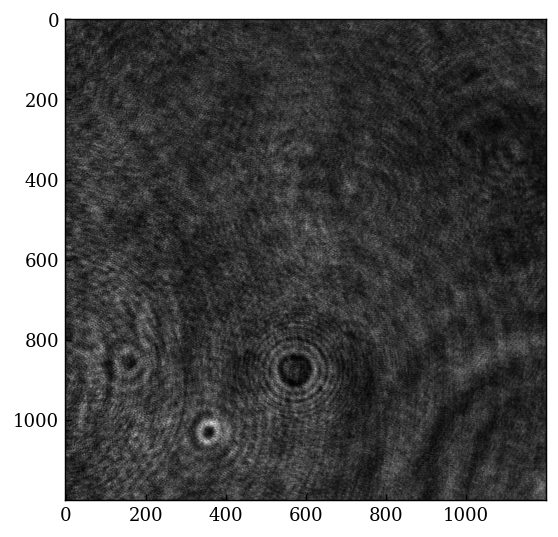

In [22]:
# Get first image and plot
image = vid.get_image(n_start)
plt.imshow(image,cmap="gray")
plt.show()

(21, 1200, 1200)


100%|███████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.33it/s]


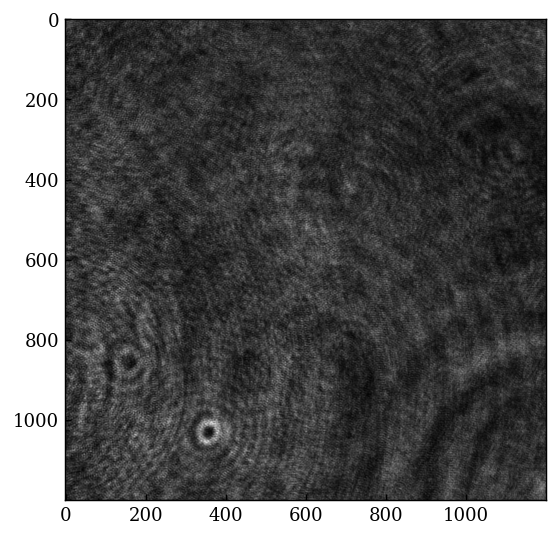

In [23]:
# Compute the background of the video
# Works for moving particles
buf, background = vid.get_background(20)
# Otherwise uncomment next line: background = mean image
# background = np.ones_like(image)* np.mean(image)
vid.background = background
plt.imshow(vid.background,cmap="gray")
plt.show()

In [24]:
#imageio.imwrite("background"+generic_output_name+".tiff", vid.background)

In [25]:
# No zeros in the bg
vid.background[vid.background == 0] = 1  

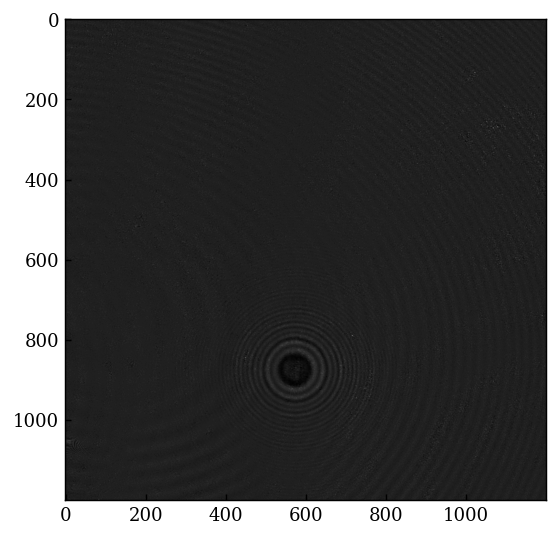

In [26]:
# Normalize first image and plot
normed_image = utilities.normalize(image, vid.background)
plt.imshow(normed_image, cmap="gray")
# normed_image = normed_image

In [27]:
# Find the center of the hologram 
feature = utilities.center_find(normed_image)
feature

/home/n.fares/.conda/envs/holography/lib/python3.9/site-packages/trackpy/feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


(None, None)

In [28]:
# Uncomment next box if nothing was found and enter approximate position manually

In [29]:
feature = [{}]

feature[0]["x_p"] = 575
feature[0]["y_p"] = 875
feature[0]["bbox"] = [200, 200, 200]

In [30]:
x, a, b = feature[0]["bbox"]

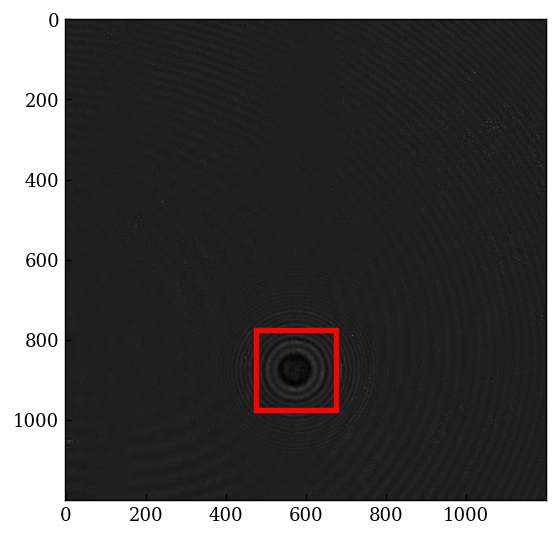

In [31]:
utilities.plot_bounding(normed_image,feature)

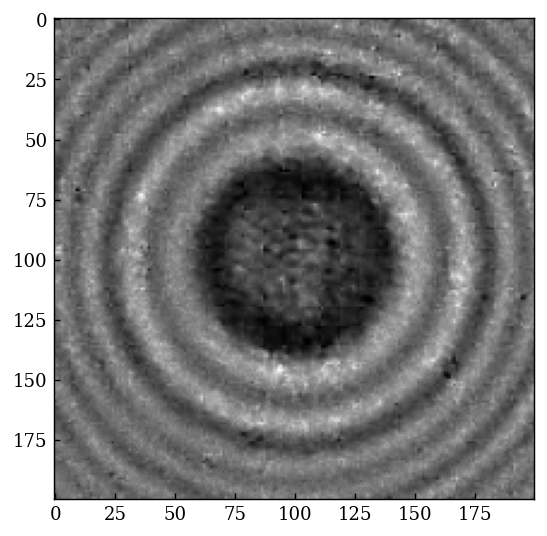

In [32]:
# More precision on the center determination
i = 0 # index of the hologram wanted
x, y, w, h = [feature[i]['x_p'], feature[i]['y_p'],*feature[i]["bbox"][1:]]
x = x - 2
y = y + 1
x_center = x
y_center = y
h = 200 # box size
im_c = fit.crop(image, int(x), int(y), int(h))
bk_c = fit.crop(vid.background, int(x), int(y), int(h))
cropped = utilities.normalize(im_c,bk_c, dark_count = np.min(im_c))
# cropped = im_c
plt.imshow(cropped,cmap = "gray")

In [33]:
# Define the fitting class
fitter = fit.fitting(cropped, wavelength, calib, n_m = n_m, percentpix=1, mask="fast", double_precision=True)
# fitter.show_mask()

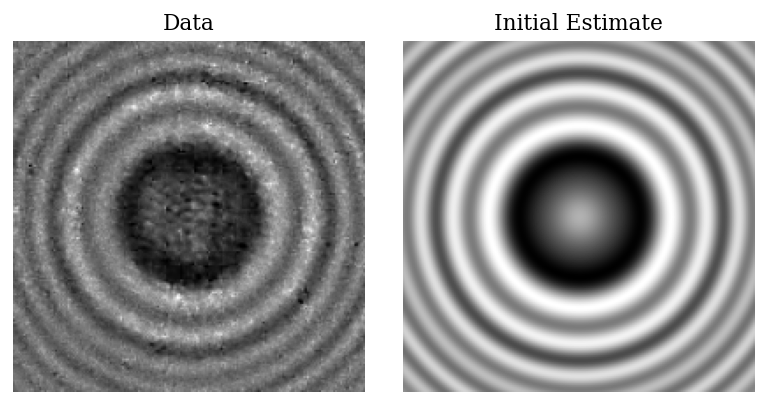

In [34]:
# First guess
# Order = radius, index, z
fitter.make_guess(1.47, 1.59, 14, show_estimate=True)

npixels = 39998
x_p = 100.8551 +- 0.0129
y_p = 99.0767 +- 0.0129
z_p = 222.5056 +- 0.1059
a_p = 1.4541 +- 0.0021
n_p = 1.5856 +- 0.0005
chisq = 1.44


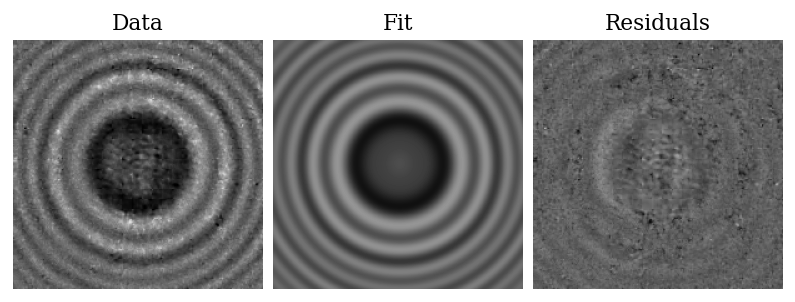

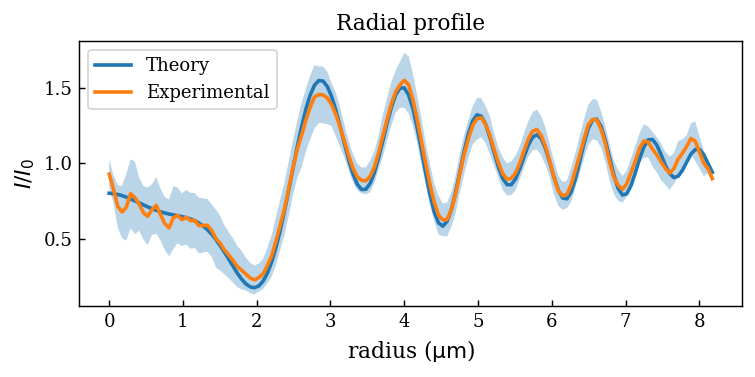

Distance to the objective (in um) = 
12.90309948828326


In [35]:
# Fit the first image 
# vary = ['x_p', 'y_p', 'z_p', 'a_p']
vary = ['x_p', 'y_p', 'z_p', "a_p", "n_p"]
fitter.set_vary(vary)
result = fitter.optimize(report = True, present=True, radial_profile = True)
print('Distance to the objective (in um) = ')
print(result['z_p'] * calib)

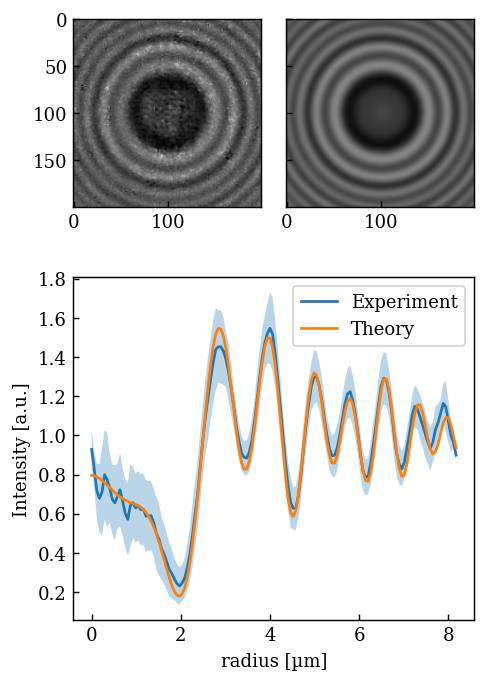

In [36]:
# Summary plot and save

fit_data = {}

fig = plt.figure(figsize=(cm2inch(10),cm2inch(15)))
fig.subplots_adjust(left=0.14, bottom=.12, right=.99, top=.98)

plt.subplot(2,2,1)
plt.imshow(fitter.feature.data, cmap = "gray", vmin=0, vmax=3)

fit_data["exp_image"] = fitter.feature.data

plt.subplot(2,2,2)
plt.imshow(fitter.feature.hologram().reshape(fitter.shape), cmap = "gray", vmin=0, vmax=3)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

fit_data["th_image"] = fitter.feature.hologram().reshape(fitter.shape)

from wraplorenzmie.pylorenzmie.utilities import azistd
center = (fitter.feature.optimize()['x_p'], fitter.feature.optimize()['y_p'])
expe_avg, expe_std = azistd(fitter.feature.data, center)
r_exp = np.arange(len(expe_avg)) * fitter.ins.magnification
th_avg, th_std = azistd(fitter.feature.hologram(), center)
r_th = np.arange(len(th_avg)) * fitter.ins.magnification

plt.subplot(2,2,(3,4))
plt.plot(r_exp, expe_avg, label="Experiment")
plt.fill_between(r_exp, expe_avg - expe_std, expe_avg + expe_std, alpha = 0.3)
plt.plot(r_th, th_avg, label="Theory")
plt.legend()
plt.xlabel("radius [µm]")
plt.ylabel("Intensity [a.u.]")

fit_data["expe_avg"] = expe_avg
fit_data["expe_std"] = expe_std
fit_data['r_exp'] = r_exp

fit_data["th_avg"] = th_avg
fit_data["th_std"] = th_std
fit_data['r_th'] = r_th

plt.tight_layout()
plt.savefig("first_im_fig_vid_{0}.pdf".format(foldername))
plt.show()

savemat('first_im_data_vid_{0}.mat'.format(foldername), fit_data)

In [37]:
# Fit images to determine r-n
fitter.fit_video(
    vid = vid, savefile="find_nr.dat", 
    xc = x_center ,yc = y_center, h=h, 
    n_start=n_start, n_end=n_start+1000, 
    method = "lm", dark_count_mode="min", loss="linear", percentpix = 0.5, 
    update_mask=True, 
    # moving_background=False, 
)

 30%|██████████████████████████▏                                                             | 297/1000 [02:16<05:23,  2.17it/s]


KeyboardInterrupt: 

In [41]:
# Get data RN from the fits
n_r = np.fromfile("find_nr.dat", dtype=np.float64)
n_r = n_r.reshape(len(n_r)//13,13)
n_r = n_r[:,:]
# n_r is an array. 
# Lines = different images 
# Columns = x, y, z, rp, np
r = n_r[:,3]
n = n_r[:,4]
# n_r = n_r.reshape(len(n_r)//4,4)
# n = n_r[:,3]

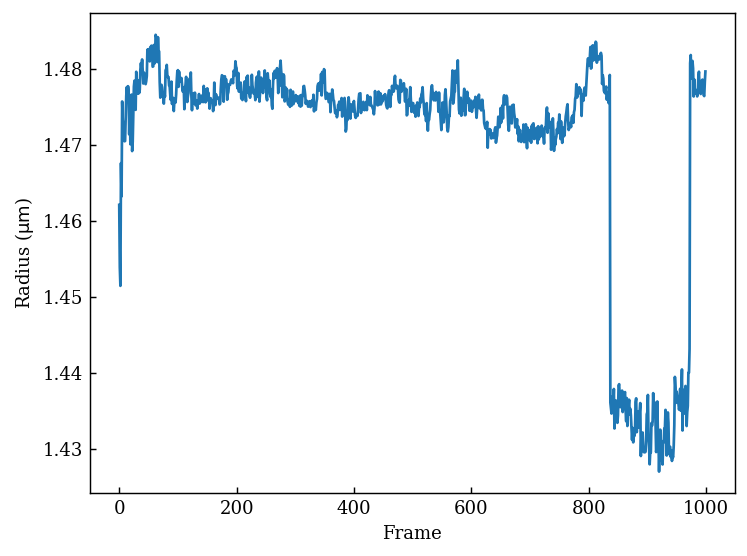

In [42]:
plt.plot(r)
plt.xlabel('Frame')
plt.ylabel(r'Radius ($\mathrm{\mu m}$)')
plt.show()

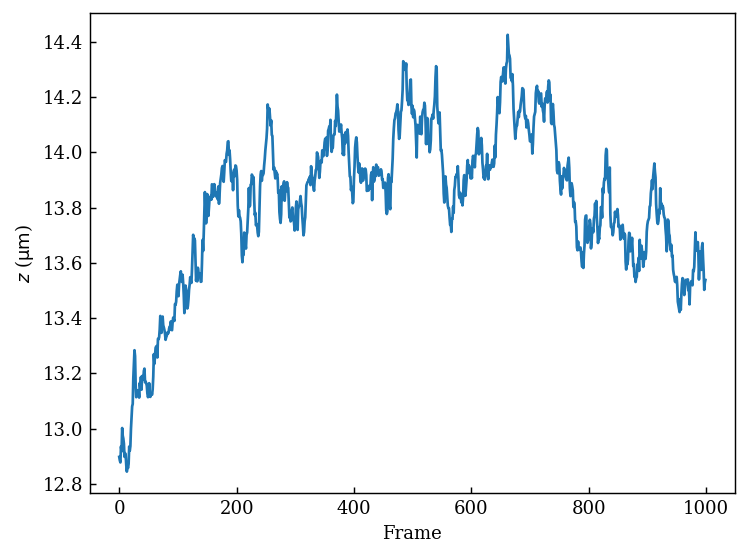

In [43]:
plt.plot(n_r[:,2]*calib)
plt.xlabel('Frame')
plt.ylabel(r'$z$ ($\mathrm{\mu m}$)')
plt.show()

/tmp/ipykernel_6872/3793861242.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r)


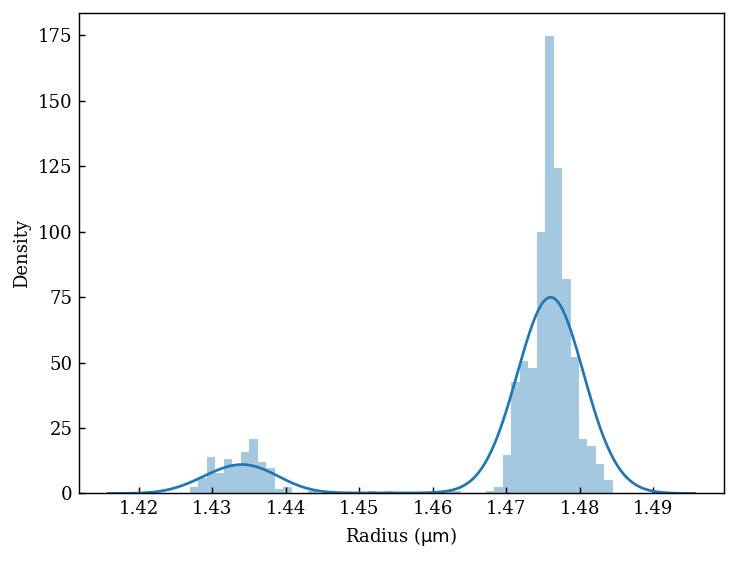

In [44]:
sns.distplot(r)
plt.xlabel(r'Radius ($\mathrm{\mu m}$)')
plt.show()

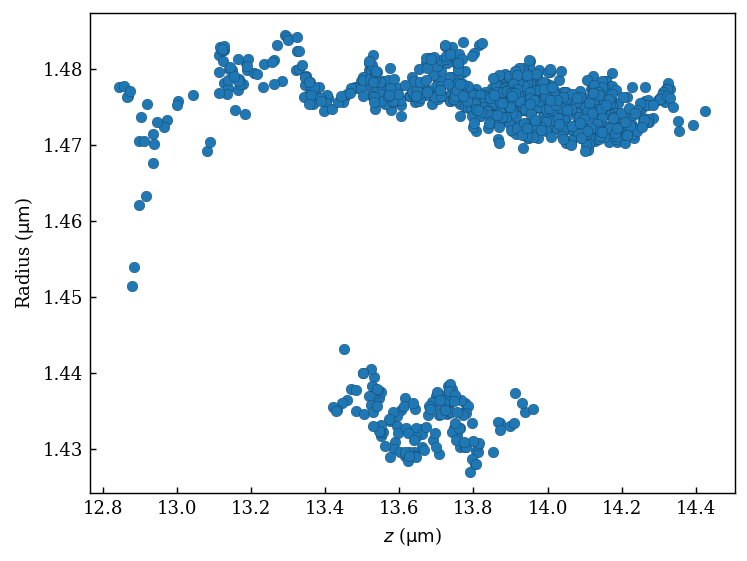

In [45]:
plt.plot(n_r[:,2]*calib, n_r[:,3], 'o')
plt.xlabel('$z$ ($\mathrm{\mu m}$)')
plt.ylabel(r'Radius ($\mathrm{\mu m}$)')
plt.show()

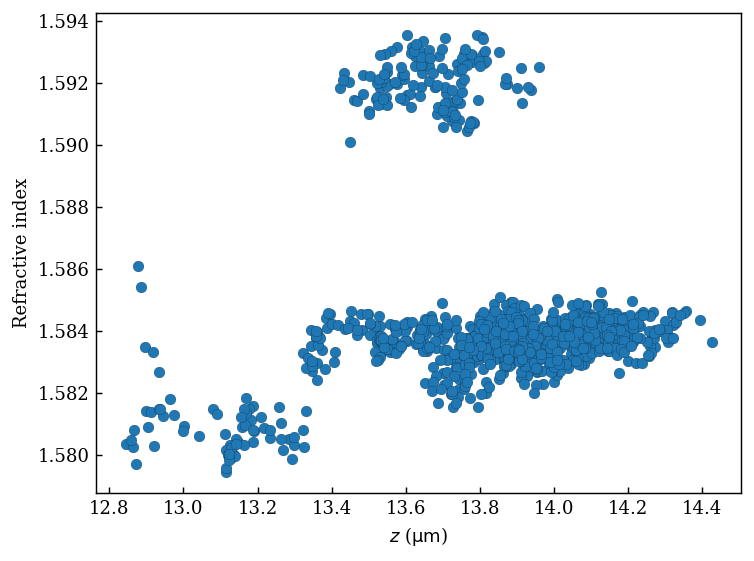

In [46]:
plt.plot(n_r[:,2]*calib, n_r[:,4], 'o')
plt.xlabel('$z$ ($\mathrm{\mu m}$)')
plt.ylabel(r'Refractive index')
plt.show()

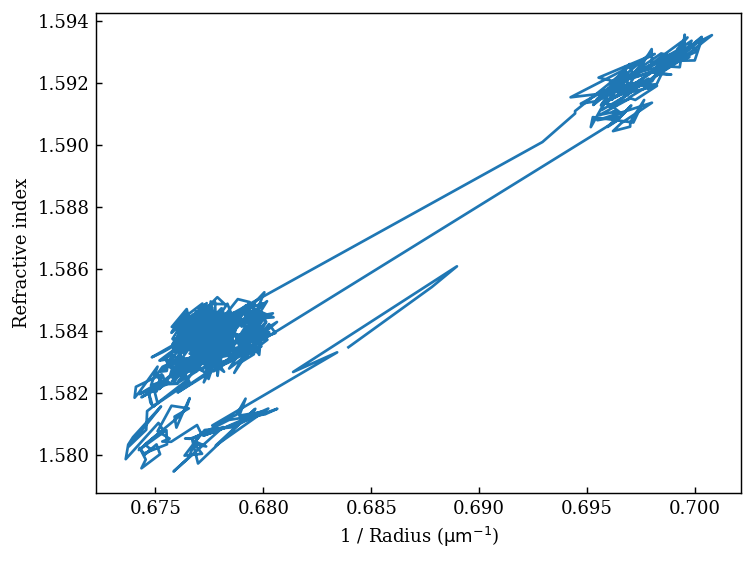

In [48]:
plt.plot(n_r[:, 3]**-1, n_r[:,4])
plt.xlabel(r'1 / Radius ($\mathrm{\mu m ^{-1}}$)')
plt.ylabel('Refractive index')
plt.show()

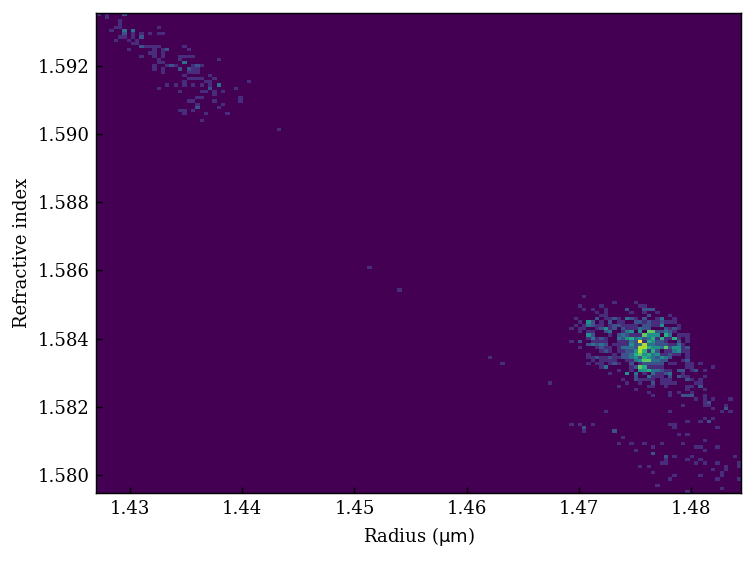

In [49]:
H, xedges, yedges = np.histogram2d(n, r, bins=100)
H = H.T  # Let each row list bins with common y range.

plt.hist2d(r,n, bins = 150)
plt.ylabel("Refractive index")
plt.xlabel("Radius ($\mathrm{\mu m}$)")
plt.show()

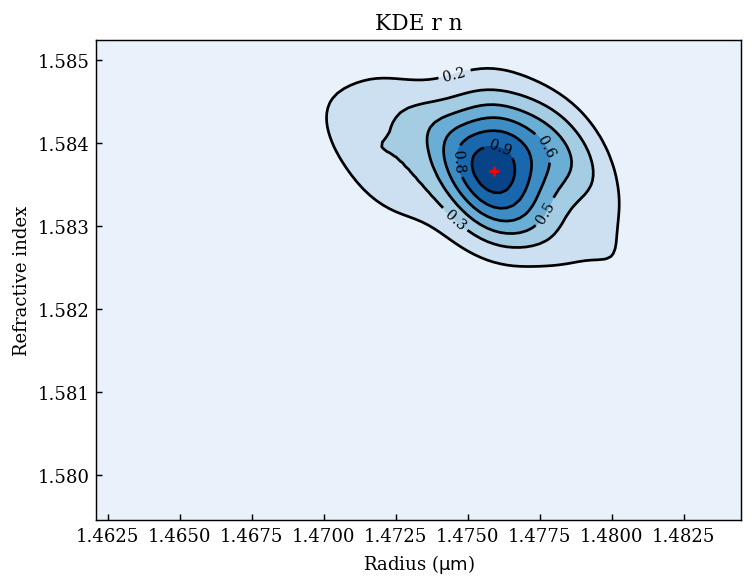

In [50]:
# Plot the 2D kernel histogram

# Choose the range of r to plot
rmin = 1.46
rmax = 1.50

import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = r[(r>rmin) & (r<rmax)]
y = n[(r>rmin) & (r<rmax)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
f = f/np.max(f)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k', levels=6)
# Label plot
ax.clabel(cset, inline=1, fontsize=8, fmt="%1.1f")
plt.scatter(xx[np.where(f == 1)],yy[np.where(f == 1)], color = "red", marker="+")
ax.set_ylabel("Refractive index")
ax.set_xlabel("Radius ($\mathrm{\mu m}$)")
plt.title("KDE r n")

plt.show()

In [51]:
print(" n determined with : mu={0}, sigma={1}".format(np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])))
print(" r determined with : mu={0}, sigma={1}".format(np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])))


mu_n, sigma_n = np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])
mu_r, sigma_r = np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])

# print(" n determined with : mu={0}, sigma={1}".format(np.mean(n), np.std(n)))
# mu_n, sigma_n = np.mean(n), np.std(n)

 n determined with : mu=1.5836605181855568, sigma=0.0005366626513130739
 r determined with : mu=1.4758995444852923, sigma=0.0023238518316273217


In [52]:
# If you want to input manually from another video

# mu_n = 1.6052716295305858
# mu_r = 1.5409155931069645
# print(mu_n)
# print(mu_r)

In [53]:
txt_rp = str(np.round(mu_r, 4))
txt_rp = txt_rp.replace('.', 'p')

txt_np = str(np.round(mu_n, 4))
txt_np = txt_np.replace('.', 'p')

In [54]:
vidsavename = 'traj_rp_{0}_np_{1}_vid_{2}'.format(txt_rp, txt_np, foldername)

In [55]:
vidsavename

'traj_rp_1p4759_np_1p5837_vid_tracking'

In [56]:
h

200

In [89]:
# Fit the whole x, y, z of t
import warnings
warnings.filterwarnings('ignore')
vary = ['x_p', 'y_p', 'z_p']
#del fitter
h = h
im_c = fit.crop(image, int(x_center), int(y_center), int(h))
bk_c = fit.crop(vid.background, int(x_center), int(y_center), int(h))
cropped = utilities.normalize(im_c,bk_c, dark_count = np.min(im_c))
cropped = cropped / np.mean(cropped)
fitter = fit.fitting(cropped,wavelength,calib, n_m = n_m, percentpix=0.1, mask="fast", double_precision = False)
fitter.make_guess(mu_r,mu_n,result["z_p"]*calib, show_estimate = False)
fitter.set_vary(vary)
fitter.fit_video(
    vid = vid,
    savefile=vidsavename+'.dat',
    xc = x_center ,yc= y_center, h=h, 
    n_start=n_start, n_end=nb_image, 
    method = "lm", loss ="linear", dark_count_mode="min", percentpix = 0.3, 
    # moving_background=False, 
)



  0%|                                                                                     | 74/126444 [00:13<6:25:05,  5.47it/s]


KeyboardInterrupt: 

In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
filename = glob.glob("traj*.dat")[0]
traj = np.fromfile(filename, dtype=np.float64)
traj = traj.reshape(len(traj)//9,9)
traj[:,:6] = traj[:,:6]
data = {
    "x": traj[:,0] * 1e-6 * calib, 
    "y": traj[:,1] * 1e-6 * calib, 
    "z": traj[:,2] * 1e-6 * calib, 
    "dx": traj[:,3] * 1e-6 * calib, 
    "dy": traj[:,4] * 1e-6 * calib, 
    "dz": traj[:,5] * 1e-6 * calib, 
    'redchi': traj[:,8], 
    'filename': glob.glob("*.mp4")[0], 
}

savemat(filename[:-4] +'.mat', data)

In [60]:
traj = traj * calib * 1e-6

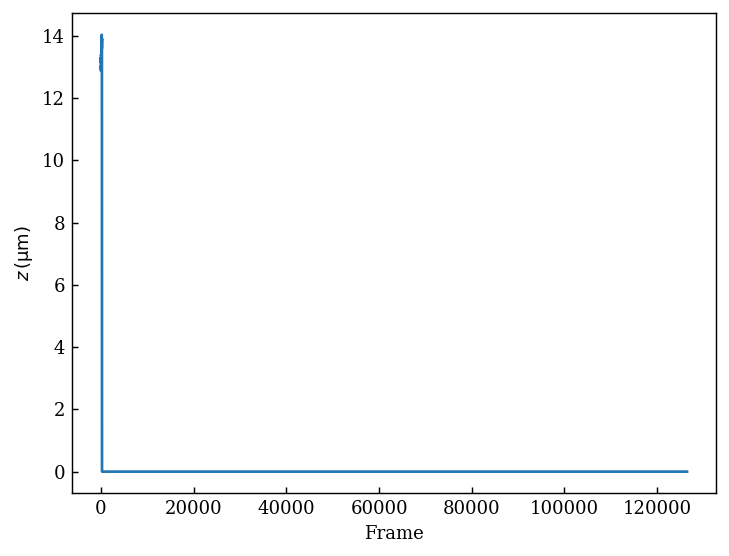

In [61]:
plt.figure()
plt.plot(traj[:,2] * 1e6)
plt.xlabel('Frame')
plt.ylabel(r'$z \, \mathrm{(\mu m)}$')
plt.show()

In [68]:
# Select a part of the trajectory
traj = traj[:100,:]

In [69]:
x, y, z = traj[:,0], traj[:,1], traj[:,2]
dx, dy, dz = traj[:,3], traj[:,4], traj[:,5]
redchi = traj[:,8]

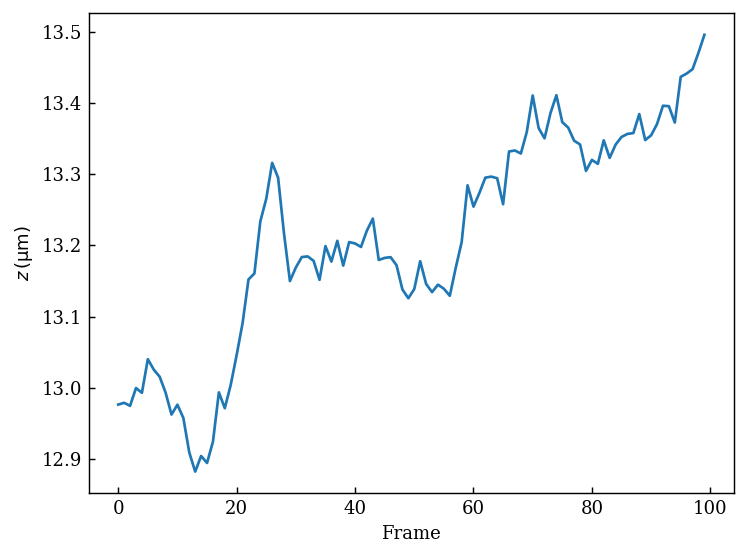

In [70]:
plt.figure()
plt.plot(traj[:,2] * 1e6)
plt.xlabel('Frame')
plt.ylabel(r'$z \, \mathrm{(\mu m)}$')
plt.show()

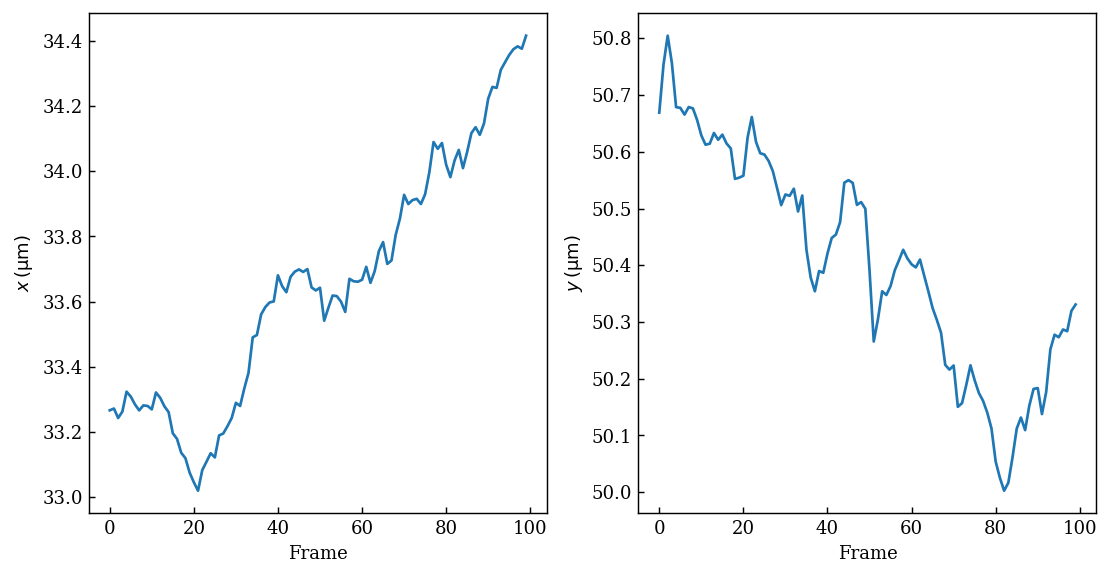

In [71]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(traj[:,0] * 1e6)
plt.xlabel('Frame')
plt.ylabel(r'$x \, \mathrm{(\mu m)}$')
plt.subplot(1, 2, 2)
plt.plot(traj[:,1] * 1e6)
plt.xlabel('Frame')
plt.ylabel(r'$y \, \mathrm{(\mu m)}$')
plt.show()

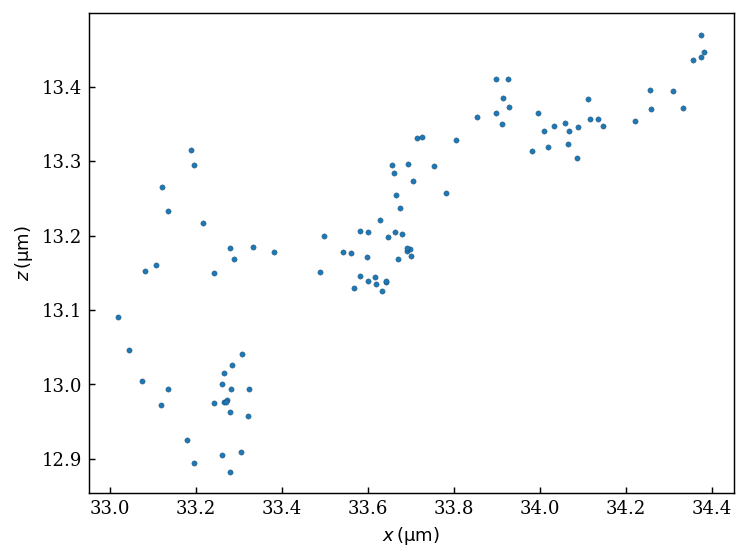

In [73]:
start = 0
stop = -1
plt.plot(traj[start:stop,0] * 1e6, traj[start:stop,2] * 1e6,".")
plt.xlabel(r'$x \, \mathrm{(\mu m)}$')
plt.ylabel(r'$z \, \mathrm{(\mu m)}$')
plt.show()

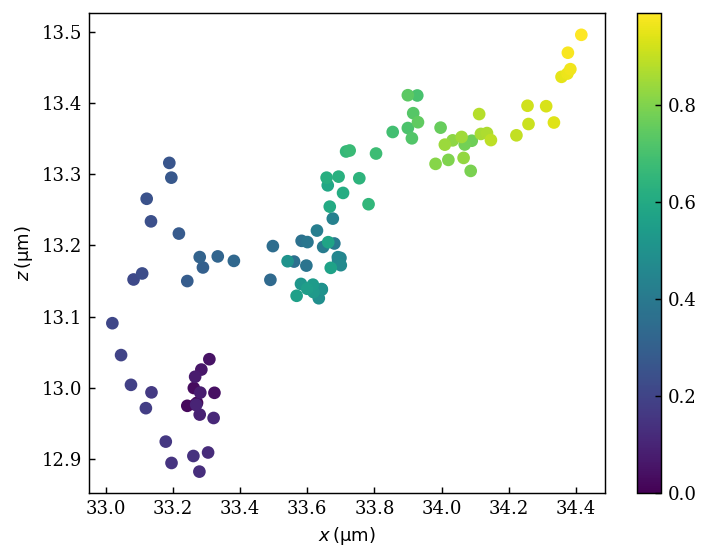

In [74]:
plt.scatter(traj[:,0] * 1e6, traj[:,2]* 1e6,cmap='viridis',c=np.arange(len(traj[:,0]))/fps)#np.arange(len(r)) / fps)
plt.colorbar()
plt.xlabel(r'$x \, \mathrm{(\mu m)}$')
plt.ylabel(r'$z \, \mathrm{(\mu m)}$')
plt.show()

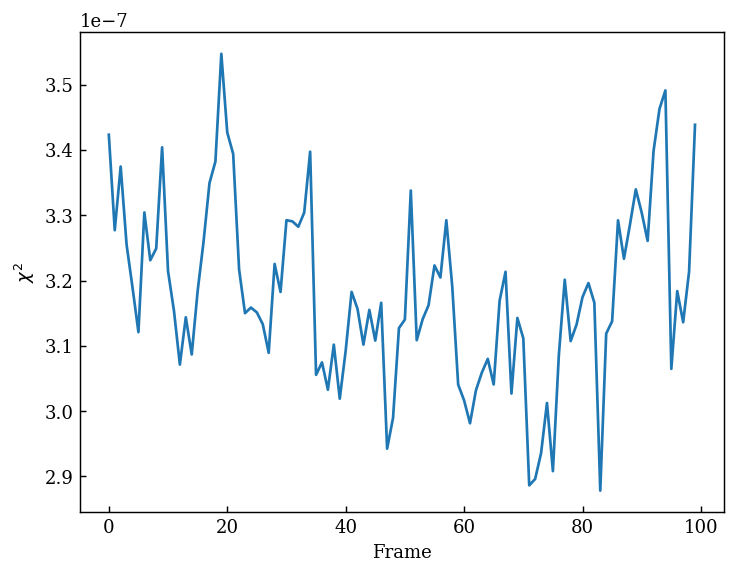

In [75]:
plt.figure()
plt.plot(redchi)
plt.xlabel(r'Frame')
plt.ylabel(r'$\chi^2$')
plt.show()

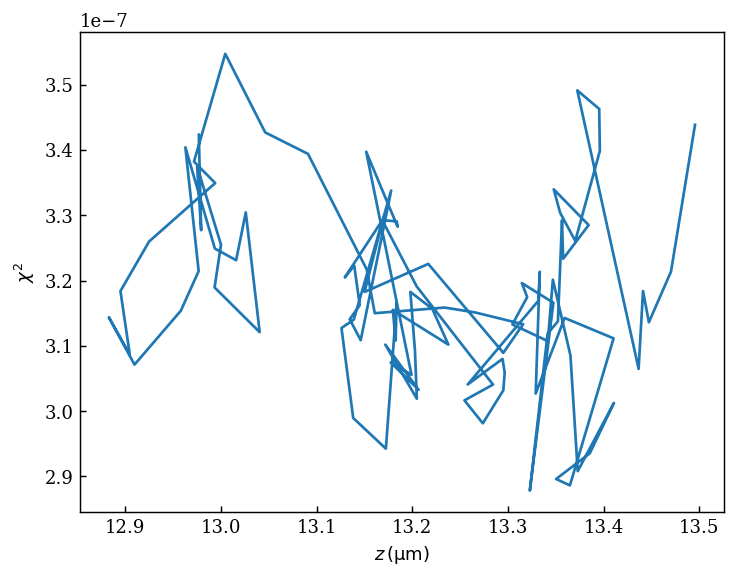

In [76]:
plt.figure()
plt.plot(z*1e6, redchi)
plt.xlabel(r'$z \, \mathrm{(\mu m)}$')
plt.ylabel(r'$\chi^2$')
plt.show()

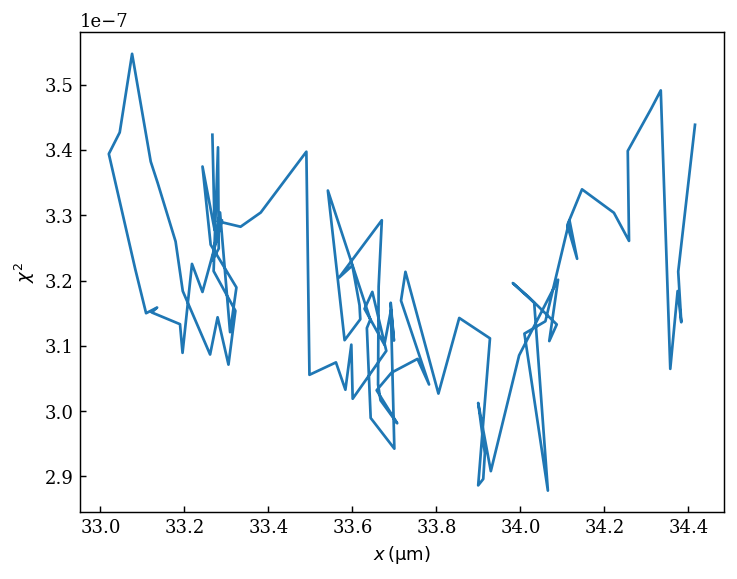

In [77]:
plt.figure()
plt.plot(x*1e6, redchi)
plt.xlabel(r'$x \, \mathrm{(\mu m)}$')
plt.ylabel(r'$\chi^2$')
plt.show()

In [78]:
# MSDs

df = np.concatenate(
    (np.linspace(1, 10, 10), np.linspace(10, 100, 100), 
    np.linspace(100, 100000, 100), 
    )
)

dt = df / fps

In [79]:
msdx = np.zeros(len(df))
msdz = np.zeros(len(df))

for i, f in enumerate(df):
    f = int(f)
    msdx[i] = np.nanmean((traj[f:,0] - traj[:-f,0])**2)
    msdz[i] = np.nanmean((traj[f:,2] - traj[:-f,2])**2)

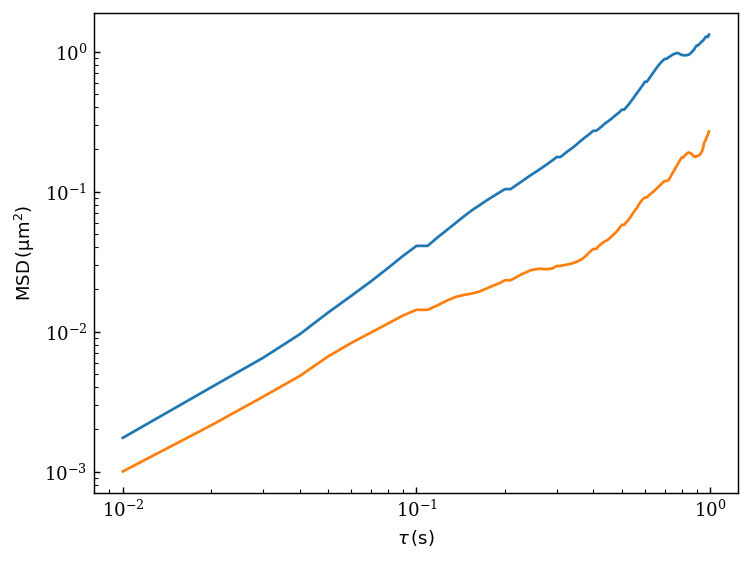

In [82]:
plt.loglog(dt, msdx * 1e12, label=r'$x$')
plt.plot(dt, msdz * 1e12, label=r'$z$')
plt.xlabel(r'$\tau \, \mathrm{(s)}$')
plt.ylabel(r'$\mathrm{MSD} \, \mathrm{(\mu m ^2)}$')
plt.show()

In [84]:
def movmin(datas, k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k/2))
    for i in range(len(datas)):
        if i < int(np.ceil(k/2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k/2)):
            end_pt = len(datas)
        result[i] = np.nanmin(datas[start_pt:end_pt])
        start_pt += 1
        end_pt += 1
    return result

In [85]:
z_dedrift = traj[:,2] - movmin(traj[:,2], 100000)

In [86]:
start = 40e-9
stop = 1e-6
nbbins = 30
base = 2
bins = np.logspace(np.log(start)/np.log(base), np.log(stop)/np.log(base), nbbins, base=base)
bins_center = (bins[1:] + bins[:-1]) / 2
widths = bins[1:] - bins[:-1]
pdf, a = np.histogram(z_dedrift, bins=bins, density=True)

In [87]:
def Peq(z, B, lD, lB):
    Ueq = B * np.exp(-z/lD) + z / lB
    res = np.exp(- Ueq)
    res = res / np.trapz(res, z)
    return res

from scipy.optimize import curve_fit

popt, _ = curve_fit(Peq, bins_center, pdf, p0=[5, 38e-9, 600e-9])

print(popt)

FloatingPointError: underflow encountered in multiply

NameError: name 'popt' is not defined

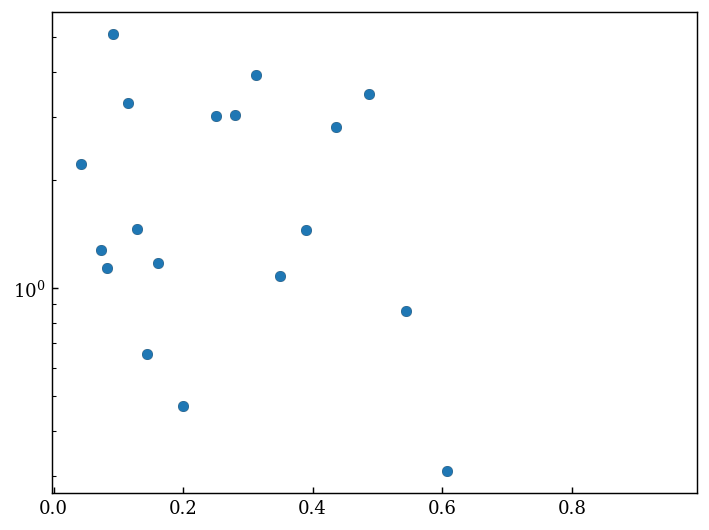

In [88]:
plt.semilogy(bins_center*1e6, pdf * 1e-6, 'o')
plt.plot(bins_center*1e6, Peq(bins_center, *popt) * 1e-6, ls='-')
plt.xlabel(r'$z \, \mathrm{(\mu m)}$')
plt.ylabel(r'$P_\mathrm{eq} \, \mathrm{(\mu m ^{-1})}$')
plt.show()